#### Graph

In [66]:
from fugw_solver.solver import solver
import torch
from collections import defaultdict

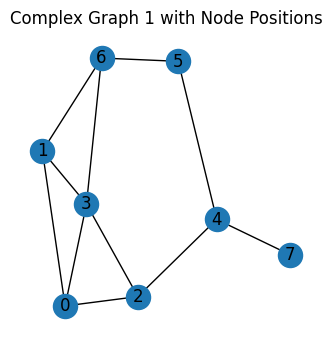

In [90]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

source_adjacency_matrix = np.array([[0, 1, 1, 1, 0, 0, 0, 0],
                             [1, 0, 0, 1, 0, 0, 1, 0],
                             [1, 0, 0, 1, 1, 0, 0, 0],
                             [1, 1, 1, 0, 0, 0, 1, 0],
                             [0, 0, 1, 0, 0, 1, 0, 1],
                             [0, 0, 0, 0, 1, 0, 1, 0],
                             [0, 1, 0, 1, 0, 1, 0, 0],
                             [0, 0, 0, 0, 1, 0, 0, 0]])

n_points_source = len(source_adjacency_matrix)

source_graph = nx.Graph(source_adjacency_matrix)

source_locations = nx.spring_layout(source_graph)

source_features = np.ones(n_points_source)

plt.figure(figsize=(3, 3))
nx.draw(source_graph, source_locations, with_labels=True)
plt.title('Complex Graph 1 with Node Positions')
plt.show()

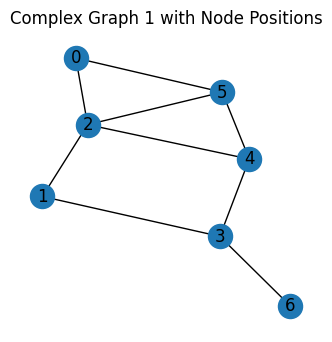

In [95]:
target_adjacency_matrix = np.array([
                             [0, 0, 1, 0, 0, 1, 0],
                             [0, 0, 1, 1, 0, 0, 0],
                             [1, 1, 0, 0, 1, 1, 0],
                             [0, 1, 0, 0, 1, 0, 1],
                             [0, 0, 1, 1, 0, 1, 0],
                             [1, 0, 1, 0, 1, 0, 0],
                             [0, 0, 0, 1, 0, 0, 0]])

n_points_target = len(target_adjacency_matrix)

target_graph = nx.Graph(target_adjacency_matrix)

target_locations = nx.spring_layout(target_graph)

target_features = np.ones(n_points_target)

plt.figure(figsize=(3, 3))
nx.draw(target_graph, target_locations, with_labels=True)
plt.title('Complex Graph 1 with Node Positions')
plt.show()

In [96]:
source_features = []
for key, value in source_locations.items():
    source_features.append(value)

target_features = []
for key, value in target_locations.items():
    target_features.append(value)

In [97]:
print(source_features)

[array([-0.4964591 , -0.30111525]), array([-0.64728348,  0.11510048]), array([-0.01306943, -0.27585911]), array([-0.35443243, -0.02730615]), array([ 0.51069528, -0.06844895]), array([0.25517884, 0.3562798 ]), array([-0.25462968,  0.36516725]), array([ 1.        , -0.16381806])]


In [98]:
source_features = torch.tensor(source_features, dtype=torch.float32)
target_features = torch.tensor(target_features, dtype=torch.float32)

print(source_features.shape, target_features.shape)

source_features_normalized = source_features / torch.linalg.norm(source_features, dim=1).reshape(-1, 1)
target_features_normalized = target_features / torch.linalg.norm(target_features, dim=1).reshape(-1, 1)

source_features_normalized = torch.transpose(source_features_normalized, 0, 1)
target_features_normalized = torch.transpose(target_features_normalized, 0, 1)

print(source_features_normalized.shape, target_features_normalized.shape)

source_geometry = torch.tensor(source_adjacency_matrix, dtype=torch.float32)
target_geometry = torch.tensor(target_adjacency_matrix, dtype=torch.float32)

w_s = torch.ones(source_features_normalized.shape[1], device='cpu') / source_features_normalized.shape[1]
w_t = torch.ones(target_features_normalized.shape[1], device='cpu') / target_features_normalized.shape[1]

torch.Size([8, 2]) torch.Size([7, 2])
torch.Size([2, 8]) torch.Size([2, 7])


In [106]:
alpha = 0.5
rho = 100
eps = 1e-4
mapping = solver(alpha=alpha, rho=rho, eps=eps, 
    source_features=source_features_normalized,
    target_features=target_features_normalized,
    source_geometry=source_geometry,
    target_geometry=target_geometry,
    device='cpu',
    w_s=w_s,
    w_t=w_t
)

In [107]:
P = mapping[0]

In [109]:
from mpl_toolkits.mplot3d.art3d import Line3DCollection

def plot_graph_matching_3D(source_locations, target_locations, source_graph, target_graph, P, distance_between_graphs):
    pos_source = source_locations
    pos_target = target_locations

    pos_source = np.array([[pos_source[key][0], pos_source[key][1], 0] for key in pos_source.keys()])
    pos_target = np.array([[pos_target[key][0], pos_target[key][1], distance_between_graphs] for key in pos_target.keys()])
    
    edges_source = list(source_graph.edges())
    segments_source = [[pos_source[edge[0]].tolist(), pos_source[edge[1]].tolist()] for edge in edges_source]
    
    edges_target = list(target_graph.edges())
    segments_target = [[pos_target[edge[0]].tolist(), pos_target[edge[1]].tolist()] for edge in edges_target]
    
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(111, projection='3d')  
    
    line_segments_source = Line3DCollection(segments_source, colors="black", lw=1, zorder=1)
    ax.add_collection(line_segments_source)  
    ax.scatter(pos_source[:, 0], pos_source[:, 1], pos_source[:, 2], color='blue', s=200, label='Source Nodes')
    
    line_segments_target = Line3DCollection(segments_target, colors="black", lw=1, zorder=1)
    ax.add_collection(line_segments_target)  
    ax.scatter(pos_target[:, 0], pos_target[:, 1], pos_target[:, 2], color='orange', s=200, label='Target Nodes')

    transport_matrix = P / P.sum(dim=1).reshape(-1, 1)

    for i in range(transport_matrix.shape[0]):
        for j in range(transport_matrix.shape[1]):
            x1, y1, z1 = pos_source[i]
            x2, y2, z2 = pos_target[j]
            ax.plot([x1, x2], [y1, y2], [z1, z2], color='red', alpha=float(transport_matrix[i, j]))

    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_zlabel('Z-axis')
    ax.set_title('Graph Matching')
    ax.legend()
    plt.show()

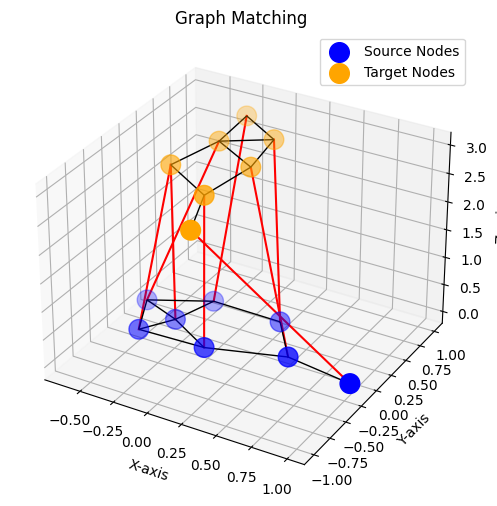

In [110]:
%matplotlib inline
plot_graph_matching_3D(source_locations, target_locations, source_graph, target_graph, P, 3)

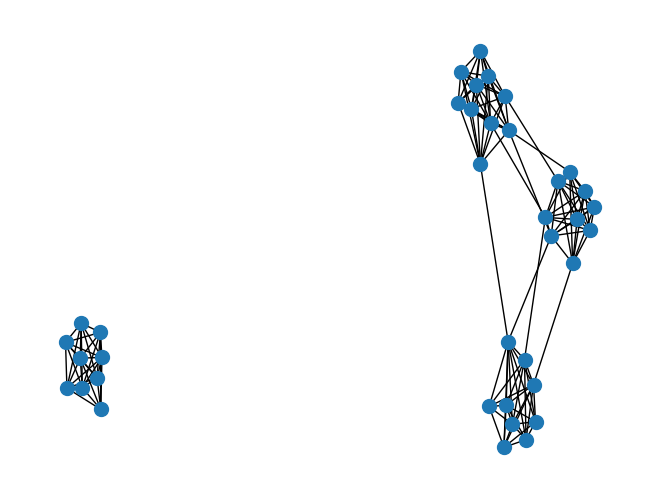

In [128]:
import random

def generate_cluster_graph(num_clusters, inter_cluster_edges=3):
    G = nx.Graph()
    cluster_sizes = [random.randint(5, 15) for _ in range(num_clusters)]
    total_points = sum(cluster_sizes)
    for i in range(total_points):
        G.add_node(i)

    current_point = 0
    for cluster_size in cluster_sizes:
        cluster_nodes = list(range(current_point, current_point + cluster_size))
        for node in cluster_nodes:
            for neighbor in cluster_nodes:
                p = np.random.rand()
                if node != neighbor and not G.has_edge(node, neighbor) and p<0.7:
                    G.add_edge(node, neighbor)
        current_point += cluster_size

    for _ in range(inter_cluster_edges):
        cluster1 = random.randint(0, num_clusters - 1)
        cluster2 = random.randint(0, num_clusters - 1)

        while cluster2 == cluster1:
            cluster2 = random.randint(0, num_clusters - 1)

        for i in range(random.randint(1,4)):
            node1 = random.choice(range(sum(cluster_sizes[:cluster1]), sum(cluster_sizes[:cluster1+1])))
            node2 = random.choice(range(sum(cluster_sizes[:cluster2]), sum(cluster_sizes[:cluster2+1])))
    
            G.add_edge(node1, node2)

    return G

num_clusters = 4
inter_cluster_edges = 3

graph = generate_cluster_graph(num_clusters, inter_cluster_edges)

pos = nx.spring_layout(graph)  
nx.draw(graph, pos, with_labels=False, node_size=100)

import matplotlib.pyplot as plt
plt.show()

#### sphere

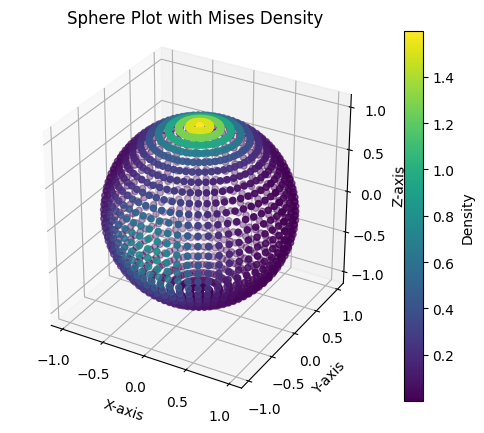

In [6]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

def mises_density(A, mu, kappa=1.0):
    cste = kappa / (4 * np.pi * np.sinh(kappa))
    density = cste * np.exp(kappa * np.dot(A,mu.T))
    return density

def create_sphere(cx, cy, cz, r, resolution=360):
    phi = np.linspace(0, 2*np.pi, 2*resolution)
    theta = np.linspace(0, np.pi, resolution)
    theta, phi = np.meshgrid(theta, phi)
    r_xy = r * np.sin(theta)
    x = cx + np.cos(phi) * r_xy
    y = cy + np.sin(phi) * r_xy
    z = cz + r * np.cos(theta)
    return x, y, z

cx, cy, cz = 0, 0, 0  # Center of the sphere
radius = 1.0
resolution = 30

x, y, z = create_sphere(cx, cy, cz, radius, resolution)

kappa_1 = 5.0  
mu_1 = np.array([0., -1., 0.])
A = np.column_stack((x.flatten(), y.flatten(), z.flatten()))
scalar_values_1 = mises_density(A, mu_1, kappa_1)

kappa_2 = 10.0  
mu_2 = np.array([0., 0., 1.])
scalar_values_2 = mises_density(A, mu_2, kappa_2)

scalar_values = scalar_values_1 + scalar_values_2

# Plot the sphere with a color gradient based on scalar values
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(x, y, z, c=scalar_values, cmap='viridis', s=20)

ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')
ax.set_aspect('equal')
ax.set_title('Sphere Plot with Mises Density')

# Add a colorbar to show the density variation
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Density')

plt.show()


In [7]:
scalar_values = scalar_values / np.linalg.norm(scalar_values)
scalar_values_1 = scalar_values_1 / np.linalg.norm(scalar_values_1)

source_features_normalized = torch.tensor(scalar_values, dtype=torch.float32).unsqueeze(0)
target_features_normalized = torch.tensor(scalar_values_1, dtype=torch.float32).unsqueeze(0)

print(source_features_normalized.sum(), target_features_normalized.sum())

source_geometry = torch.tensor(A, dtype=torch.float32)
source_geometry = torch.cdist(source_geometry, source_geometry)
target_geometry = source_geometry

w_s = torch.ones(source_features_normalized.shape[1], device='cpu') / source_features_normalized.shape[1]
w_t = torch.ones(target_features_normalized.shape[1], device='cpu') / target_features_normalized.shape[1]

tensor(22.0808) tensor(16.5134)


In [8]:
alpha = 0.5
rho = 1
eps = 1e-4
mapping = solver(alpha=alpha, rho=rho, eps=eps, 
    source_features=source_features_normalized,
    target_features=target_features_normalized,
    source_geometry=source_geometry,
    target_geometry=target_geometry,
    device='cpu',
    w_s=w_s,
    w_t=w_t
)

/Users/juliengenzling/Desktop/FUGW/fugw_solver/solver.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  F_s = torch.tensor(source_features.T, device=device)
/Users/juliengenzling/Desktop/FUGW/fugw_solver/solver.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  F_t = torch.tensor(target_features.T, device=device)
/Users/juliengenzling/Desktop/FUGW/fugw_solver/solver.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  D_s = torch.tensor(source_geometry, device=device)
/Users/juliengenzling/Desktop/FUGW/fugw_solver/solver.py:15: UserW

In [9]:
P, loss_ls = mapping

loss = defaultdict(list)
for l in loss_ls:
    for k,v in l.items():
        loss[k].append(v)

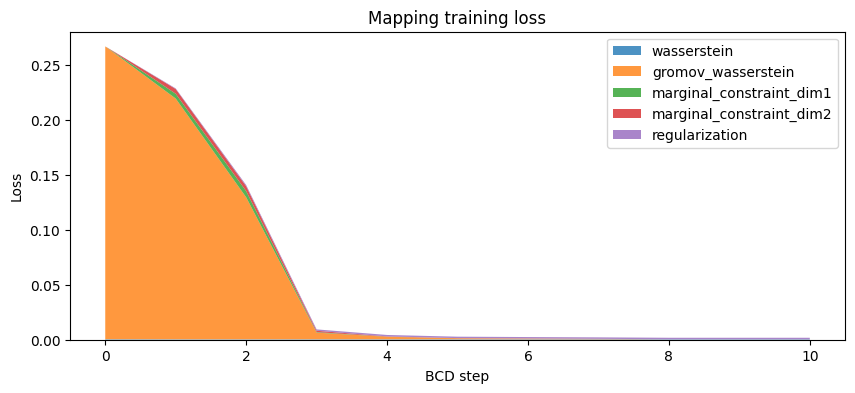

In [10]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.set_title("Mapping training loss")
ax.set_ylabel("Loss")
ax.set_xlabel("BCD step")
ax.stackplot(
    np.arange(len(loss_ls)),
    [
        (1 - alpha) * np.array(loss["wasserstein"]),
        alpha * np.array(loss["gromov_wasserstein"]),
        rho * np.array(loss["marginal_constraint_dim1"]),
        rho * np.array(loss["marginal_constraint_dim2"]),
        eps * np.array(loss["regularization"]),
    ],
    labels=[
        "wasserstein",
        "gromov_wasserstein",
        "marginal_constraint_dim1",
        "marginal_constraint_dim2",
        "regularization",
    ],
    alpha=0.8,
)
ax.legend()
plt.show()

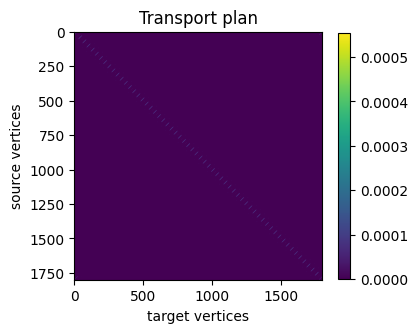

In [11]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.set_title("Transport plan")
ax.set_xlabel("target vertices")
ax.set_ylabel("source vertices")
im = plt.imshow(P, cmap="viridis")
plt.colorbar(im, ax=ax, shrink=0.8)
plt.show()

In [12]:
P.sum()

tensor(0.9999)

In [13]:
predicted_features = P.T@source_features_normalized.T
predicted_features = predicted_features.squeeze(0)

In [14]:
predicted_features.sum()

tensor(0.0123)

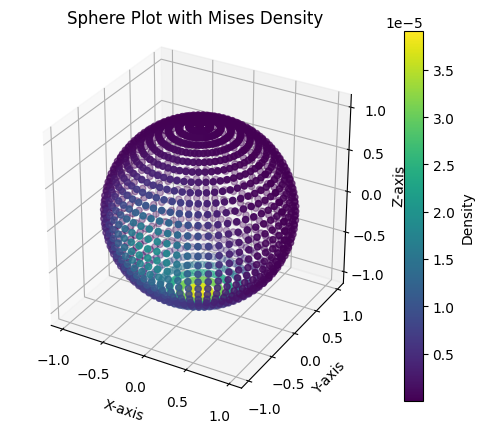

In [15]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(x, y, z, c=predicted_features, cmap='viridis', s=20)

ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')
ax.set_aspect('equal')
ax.set_title('Sphere Plot with Mises Density')

# Add a colorbar to show the density variation
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Density')

plt.show()